In [ ]:
import nltk
import numpy as np
import pandas as pd

import string
import re
from sklearn.feature_extraction import _stop_words
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

import matplotlib.pyplot as plt
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


In [ ]:
! pip install kneed

In [ ]:
!mkdir org

In [ ]:
!mv *.csv org/

In [ ]:
!mv *.csv org/

In [ ]:
import pandas as pd
import os
import random

# Initialize an empty list to store the information feed
information_feed = []
organizations = []

for filename in filter(lambda filename: filename.endswith('.csv'), os.listdir('/content/org')):
    organizations.append([filename.removesuffix('.csv'), 0])
    al = pd.read_csv(f"org/{filename}")
    for index, row in al.iterrows():
        organizations[-1][1] += 1
        feed = str(row["name"]) + " " + (str(row["description"]) if pd.notnull(row["description"]) else " ")# + (str(row["readme"]) if pd.notnull(row["readme"]) else " ")
        information_feed.append(feed)

weights = []
for org in organizations:
    nrepo = org[1]
    for i in range(nrepo):
        weights.append(1/nrepo)

# weights = sum([[1/nrepo]*nrepo for nrepo in map(lambda pair: pair[1], organizations)])
information_feed = random.choices(information_feed, weights, k=500)

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')
wn = WordNetLemmatizer()

def preprocess_text(text):
    text = text.lower()
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\d+', '', text)
    tokens = text.split()
    text = [wn.lemmatize(word) for word in tokens if word not in stopwords and len(word) > 2]
    return text

In [ ]:
vectorizer = TfidfVectorizer(analyzer = preprocess_text, stop_words='english')
X = vectorizer.fit_transform(information_feed)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:550: UserWarning: The parameter 'stop_words' will not be used since 'analyzer' != 'word'
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


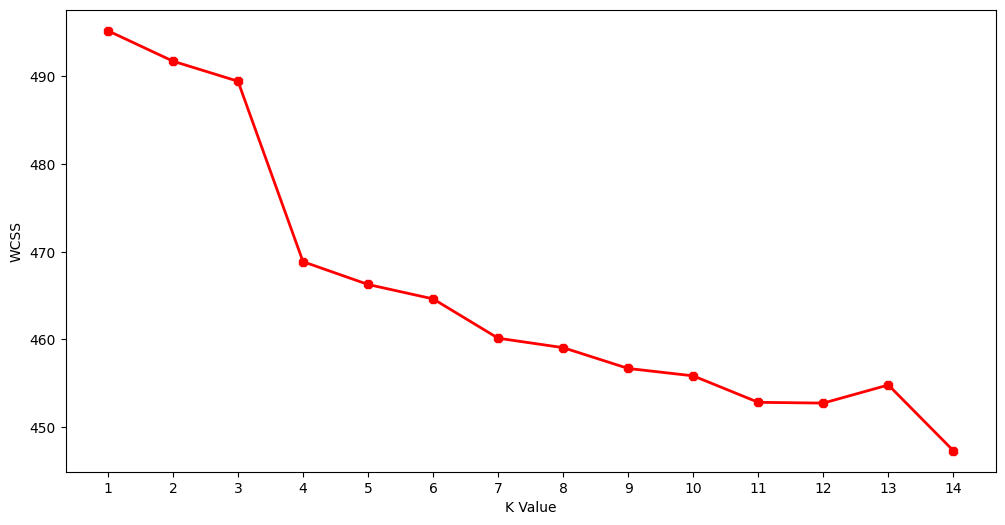

In [ ]:
import matplotlib.pyplot as plt
wcss=[]

for i in range(1,15):
    km=KMeans(n_clusters=i)
    km.fit(X)
    wcss.append(km.inertia_)

plt.figure(figsize=(12,6))
plt.plot(range(1,15),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel("K Value")
plt.xticks(np.arange(1,15,1))
plt.ylabel("WCSS")
plt.show()

In [ ]:
from kneed import KneeLocator

k_values = list(range(1, 15))

kneedle = KneeLocator(k_values, wcss, curve='convex', direction='decreasing')

elbow_point = kneedle.elbow

print(f"The elbow point is at cluster number: {elbow_point}")

The elbow point is at cluster number: 7


In [ ]:
true_k = 7
model = KMeans(n_clusters=true_k, init='k-means++', max_iter=100, n_init=1)
model.fit(X)

print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names_out()
for i in range(true_k):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])

Top terms per cluster:
Cluster 0:
 package
 solution
 mirror
 exp
 apps
 experimental
 deprecated
 time
 similarity
 web
Cluster 1:
 linux
 source
 tree
 kernel
 code
 library
 tool
 agglayer
 mirror
 implementation
Cluster 2:
 documentation
 cardano
 python
 translation
 docscardanoorg
 sorobandocs
 soroban
 graphql
 cardanographql
 cfcipfrontend
Cluster 3:
 repository
 aws
 official
 image
 docker
 lld
 moved
 container
 github
 amazon
Cluster 4:
 ticket
 lottery
 reimplementation
 mnist
 lotterytickethypothesis
 frankle
 carbin
 hypothesis
 migration
 sagetracmirror
Cluster 5:
 public
 parameter
 multiparty
 computation
 zksnark
 sapling
 zcashs
 saplingmpc
 opamrepository
 opam
Cluster 6:
 rust
 jsonrpc
 implementation
 foundry
 simpleinfra
 automation
 infrastructure
 contract
 binding
 zkstarks


In [ ]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import word_tokenize
import smart_open
from gensim.parsing.preprocessing import strip_punctuation, remove_stopwords
from transformers import BertModel, BertTokenizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import spacy
import torch
import re
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage

In [ ]:
# use "bert-base-uncased" for embedding
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

inputs = tokenizer(information_feed, padding=True, truncation=True, max_length=128, return_tensors="pt")

with torch.no_grad():
    outputs = model(**inputs)
    embeddings = outputs.last_hidden_state.mean(dim=1).numpy()

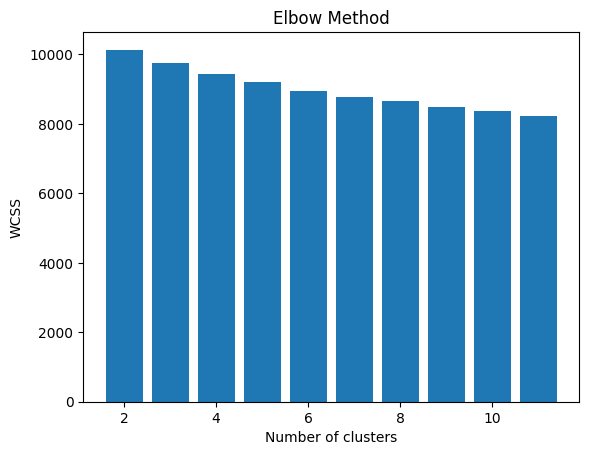

In [ ]:
# used elbow method for determining the number of clusters
wcss = []
for i in range(2, 12):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=1000, n_init=10, random_state=0)
    kmeans.fit(embeddings)
    wcss.append(kmeans.inertia_)
plt.bar(range(2, 12), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [ ]:
# find knee point to precisely determine cluster number
from kneed import KneeLocator

k_values = list(range(2, 12))

kneedle = KneeLocator(k_values, wcss, curve='convex', direction='decreasing')

elbow_point = kneedle.elbow

print(f"The elbow point is at cluster number: {elbow_point}")

The elbow point is at cluster number: 6


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


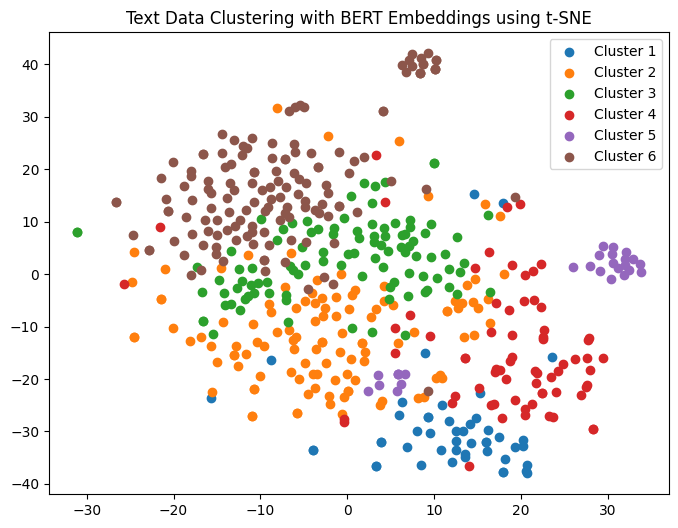

In [ ]:
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import json

# Assuming 'embeddings' is your array of BERT embeddings and 'json_data' contains your text data
num_clusters = 6
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans.fit(embeddings)
labels = kmeans.labels_

# Use t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
reduced_embeddings = tsne.fit_transform(embeddings)

# Plotting
plt.figure(figsize=(8, 6))
for i in range(num_clusters):
    plt.scatter(reduced_embeddings[labels == i, 0], reduced_embeddings[labels == i, 1], label=f"Cluster {i+1}")


plt.title("Text Data Clustering with BERT Embeddings using t-SNE")
plt.legend()
plt.savefig("textdata_tsne.pdf")
plt.show()